# In-Depth Movie Investigation

### Question 1 : Is there a correlation between the revenue of a movie and it's budget?

The r-squared between revenue and production budget is only 0.2275, meaning that only 22.75% of the dependent variable variation is explained by the linear model.
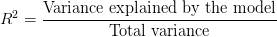

The density plot returns a Pearson correlation coefficient of 0.48, showing that the revenue of a movie and it's budget *are* correlated. However, the correlation is only moderately positive. The two variables are not strongly correlated.
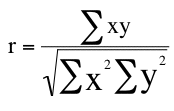

### Question 2 : Do movies generate more revenue domestically or abroad?

On an absolute basis, the largest portion of a movie's revenue is it's domestic sales. The r-squared between the two variables is 0.839, showing a strong linear relationship. Furthermore, the pearson's r is 0.92, which also shows a strong correlation.

On average, domestic gross comprises 61.9% of a movie's total gross, while foreign sales only make up about 38.1%

While foreign gross has a stronger correlation with revenue, this is likely due to it's smaller variation.

Ideally movie-making companies should focus their advertising campaigns primarily on the domestic market, as it represents, on average, a greater portion of potential revenue.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
import bs4 as bs
import urllib.request 
from html_table_parser import HTMLTableParser 
import csv
import seaborn as sns
import scipy.stats as stats
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from IPython.core.display import HTML 

In [25]:
title_crew = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\title.crew.csv')
movie_gross = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\bom.movie_gross.csv')
name_basics = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\name.basics.csv')
title_akas = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\title.akas.csv')
title_basics = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\title.basics.csv')
title_crew = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\title.crew.csv')
title_principals = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\title.principals.csv')
title_ratings = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\title.ratings.csv')
tmdb_movies = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\tmdb.movies.csv')
tn_movie_budgets = pd.read_csv(r'C:\Users\Nick\Downloads\dsc-phase-1-project-online-master\dsc-phase-1-project-online-master\zippedData\tn.movie_budgets.csv')

In [26]:
# standardizes the date format of the release date column

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets.release_date)

In [27]:
# creates a list of numbers

numbers = ['1','2','3','4','5','6','7','8','9','0'] 

# a function that removes the string characters such as "$" or "," by using the list created above

def convertToInt(column):
    return int(''.join(filter(lambda x: x in numbers, column)))

In [28]:
# cleans the columns by passing the convertToInt fucnti

tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].apply(convertToInt)
tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].apply(convertToInt)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].apply(convertToInt)

In [29]:
# scrapes the inflation table from usinflationcalculator.com

from urllib.request import urlopen

from urllib.error import HTTPError

from bs4 import BeautifulSoup

try:


    source = urllib.request.urlopen('https://www.usinflationcalculator.com/inflation/historical-inflation-rates/').read()


except HTTPError as e:

    print(e)
    
else:    
    
    soup = bs.BeautifulSoup(source,'lxml')
    table = soup.find('table')
    table_rows = table.find_all('tr')

# creates an empty list to append scraped data to

    inflation_data = []

# loops through the scraped data and appends it to the empty list 

    for tr in table_rows:
        td = tr.find_all('td')
        row = [i.text for i in td]
        inflation_data.append(row)

In [30]:
# turns the list of lists into a pandas DataFrame

pd_infl_data = pd.DataFrame(inflation_data)

In [31]:
# renames the columns in the pandas DataFrame

pd_infl_data.columns = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC','AVE']

In [32]:
# drops the first two rows and calculates the mean of the AVE column

infl_data_drop_nulls = pd_infl_data.drop([0,1])
mean_inflation = pd.to_numeric(pd_infl_data['AVE'], errors='coerce').mean()
print(mean_inflation)

3.2207547169811335


In [33]:
# creates a column with the mean inflation 

infl_data_drop_nulls.index = infl_data_drop_nulls.index - 2
years_list = list(range(1915, 2021))
infl_data_drop_nulls['years'] = years_list
infl_data_drop_nulls['mean inflation'] = 1 + (pd.to_numeric(pd_infl_data['AVE'], errors='coerce').mean()/100)

In [34]:
# creates a multiplier indexed by year with 1915 being 0

infl_data_drop_nulls['mult'] = round((1) / infl_data_drop_nulls['mean inflation'] ** infl_data_drop_nulls.index,4)

In [35]:
# creates a dictionary, 
# the key values are the years 1915-2019 
# item values are the corresponding values from the mult column of infl_data_drop_nulls

inflation_dict = dict(zip(list(infl_data_drop_nulls['years']), list(infl_data_drop_nulls['mult'])))

In [36]:
# creates a function that takes the year and multiplies it by it's dictionary item value

def adjust_for_inflation(x, column):
    '''Takes in a row and the column of the value to adjust'''
    date_str = str(x.release_date)
    year_str = date_str.split('-')[0]
    return round(inflation_dict[int(year_str)] * x[column],2)

In [37]:
tn_movie_budgets['total_gross'] = tn_movie_budgets['worldwide_gross'] + tn_movie_budgets['domestic_gross']
tn_movie_budgets['total_gross_adjusted'] = tn_movie_budgets['total_gross'] = tn_movie_budgets.apply(lambda x: adjust_for_inflation(x, 'total_gross'),axis=1)
tn_movie_budgets['worldwide_gross_adjusted'] = tn_movie_budgets.apply(lambda x: adjust_for_inflation(x, 'worldwide_gross'),axis=1)
tn_movie_budgets['production_budget_adjusted'] = tn_movie_budgets.apply(lambda x: adjust_for_inflation(x, 'production_budget'),axis=1)
tn_movie_budgets['domestic_gross_adjusted'] = tn_movie_budgets.apply(lambda x: adjust_for_inflation(x, 'domestic_gross'),axis=1)
tn_movie_budgets['revenue_adjusted'] = tn_movie_budgets['worldwide_gross_adjusted'] - tn_movie_budgets['production_budget_adjusted']
tn_movie_budgets['foreign_gross'] = tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['domestic_gross']
tn_movie_budgets['foreign_gross_adjusted'] =tn_movie_budgets['worldwide_gross_adjusted'] - tn_movie_budgets['domestic_gross_adjusted']
tn_movie_budgets['domestic_gross_adj_percentage'] = (tn_movie_budgets['domestic_gross_adjusted'] / tn_movie_budgets['worldwide_gross_adjusted']) * 100
tn_movie_budgets['foreign_gross_adj_percentage'] = (tn_movie_budgets['foreign_gross_adjusted'] / tn_movie_budgets['worldwide_gross_adjusted']) * 100
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total_gross,total_gross_adjusted,worldwide_gross_adjusted,production_budget_adjusted,domestic_gross_adjusted,revenue_adjusted,foreign_gross,foreign_gross_adjusted,domestic_gross_adj_percentage,foreign_gross_adj_percentage
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,1.796721e+08,1.796721e+08,1.410383e+08,21590000.00,38633787.35,1.194483e+08,2015837654,1.024046e+08,27.392401,72.607599
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,6.137691e+07,6.137691e+07,4.987817e+07,19585620.00,11498746.84,3.029255e+07,804600000,3.837942e+07,23.053668,76.946332
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,7.123414e+06,7.123414e+06,5.541207e+06,12950000.00,1582206.95,-7.408793e+06,107000000,3.959000e+06,28.553472,71.446528
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,7.820483e+07,7.820483e+07,5.892659e+07,13885200.00,19278246.46,4.504139e+07,944008095,3.964834e+07,32.715702,67.284298
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,7.631398e+07,7.631398e+07,5.187884e+07,12489800.00,24435146.45,3.938904e+07,696540365,2.744369e+07,47.100413,52.899587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,0.000000e+00,0.000000e+00,0.000000e+00,267.40,0.00,-2.674000e+02,0,0.000000e+00,NaN,NaN
5778,79,1999-04-02,Following,6000,48482,240495,2.017059e+04,2.017059e+04,1.678655e+04,418.80,3384.04,1.636775e+04,192013,1.340251e+04,20.159235,79.840765
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,1.544100e+02,1.544100e+02,7.720000e+01,288.50,77.20,-2.113000e+02,0,0.000000e+00,100.000000,0.000000
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,0.000000e+00,0.000000e+00,0.000000e+00,58.80,0.00,-5.880000e+01,0,0.000000e+00,NaN,NaN


In [38]:
print(tn_movie_budgets['domestic_gross_adj_percentage'].mean())
print(tn_movie_budgets['foreign_gross_adj_percentage'].mean())

61.90718514382962
38.092814856170314


Text(-5000000, 10000000, 'R-squared:0.2275')

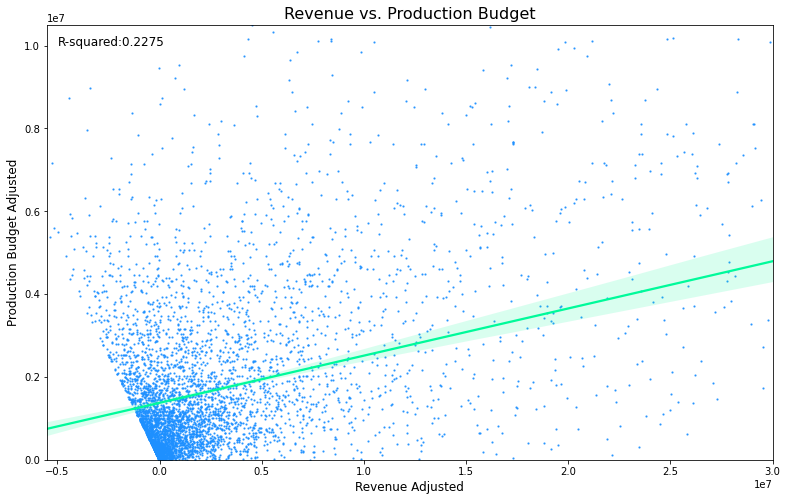

In [39]:
# scatterplot of the two variables with linear regression

fig = plt.figure(figsize=(13,8))
sns.regplot(x=tn_movie_budgets['revenue_adjusted'], y=tn_movie_budgets['production_budget_adjusted'], marker='o', color='dodgerblue', scatter_kws={'s':1.5}, line_kws={"color": "mediumspringgreen"}).set(xlim=(-5500000, 30000000))
plt.ylim(0, 10500000)

# sets the labels and titles of the plot

plt.title('Revenue vs. Production Budget', y=1.0, fontsize =16)
plt.xlabel('Revenue Adjusted', fontsize=12) 
plt.ylabel("Production Budget Adjusted", fontsize=12)

# calculates the linear regression values using scipy's linregress function

slope, intercept, r_value, p_value, std_err = stats.linregress(tn_movie_budgets['revenue_adjusted'], [tn_movie_budgets['production_budget_adjusted']])

# squares the r-value from the linear regression to find R-squared

plt.text(-5000000, 10000000, 'R-squared:' + str(round((r_value**2),4)) , fontsize=12)

Text(200000, 29000000, 'R-squared:0.839')

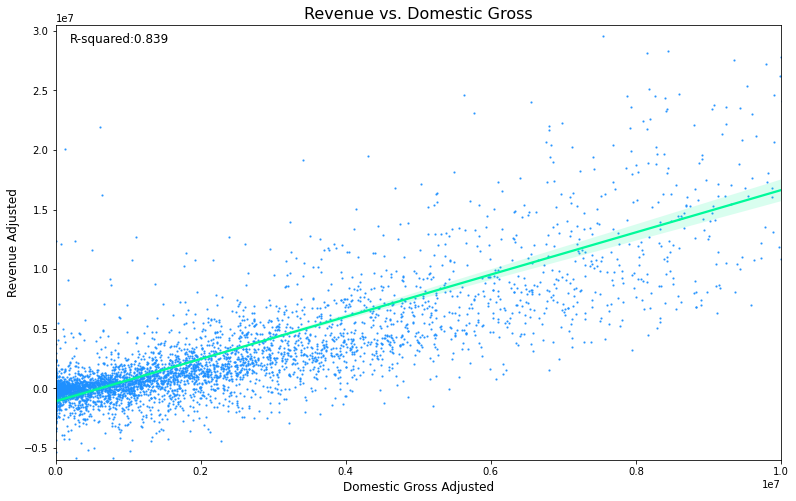

In [40]:
# scatterplot of the two variables with linear regression

fig = plt.figure(figsize=(13,8))
sns.regplot(x=tn_movie_budgets['domestic_gross_adjusted'], y=tn_movie_budgets['revenue_adjusted'], marker='o', color='dodgerblue', scatter_kws={'s':1.5}, line_kws={"color": "mediumspringgreen"}).set(xlim=(0, 10000000))
plt.ylim(-6000000, 30500000)

# sets the labels and titles of the plot

plt.title('Revenue vs. Domestic Gross', y=1.0, fontsize = 16)
plt.xlabel('Domestic Gross Adjusted', fontsize=12) 
plt.ylabel("Revenue Adjusted", fontsize=12)

# calculates the linear regression values using scipy's linregress function

slope, intercept, r_value, p_value, std_err = stats.linregress(tn_movie_budgets['revenue_adjusted'], [tn_movie_budgets['domestic_gross_adjusted']])

# squares the r-value from the linear regression to find R-squared

plt.text(200000, 29000000, 'R-squared:' + str(round((r_value**2),4)) , fontsize=12)

Text(500000, 33000000, 'R-squared:0.8617')

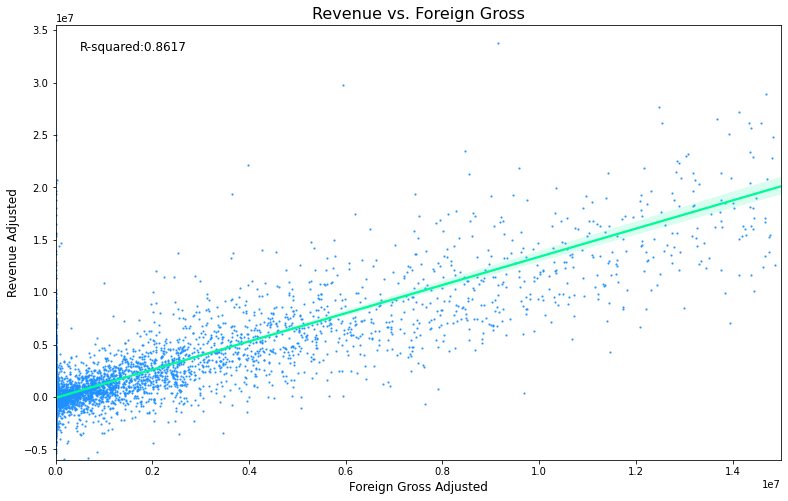

In [41]:
# scatterplot of the two variables with linear regression

fig = plt.figure(figsize=(13,8))
sns.regplot(x=tn_movie_budgets['foreign_gross_adjusted'], y=tn_movie_budgets['revenue_adjusted'], marker='o', color='dodgerblue', scatter_kws={'s':1.5}, line_kws={"color": "mediumspringgreen"}).set(xlim=(0, 15000000))
plt.ylim(-6000000, 35500000)

# sets the labels and titles of the plot

plt.title('Revenue vs. Foreign Gross', y=1.0, fontsize = 16)
plt.xlabel('Foreign Gross Adjusted', fontsize=12)
plt.ylabel('Revenue Adjusted', fontsize=12)

# calculates the linear regression values using scipy's linregress function

slope, intercept, r_value, p_value, std_err = stats.linregress(tn_movie_budgets['revenue_adjusted'], [tn_movie_budgets['foreign_gross_adjusted']])

# squares the r-value from the linear regression to find R-squared

plt.text(500000, 33000000, 'R-squared:' + str(round((r_value**2),4)) , fontsize=12)

Text(200000, 21000000, 'R-squared:0.9588')

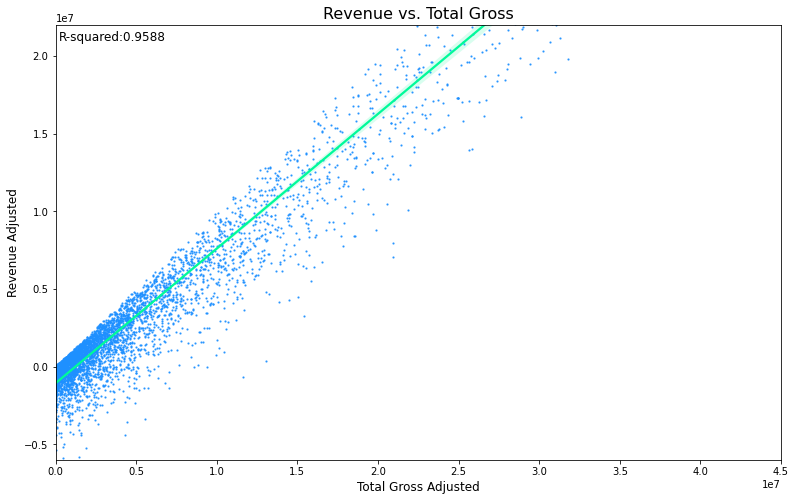

In [42]:
# scatterplot of the two variables with linear regression

fig = plt.figure(figsize=(13,8))
sns.regplot(x=tn_movie_budgets['worldwide_gross_adjusted'], y=tn_movie_budgets['revenue_adjusted'], marker='o', color='dodgerblue', scatter_kws={'s':1.5}, line_kws={"color": "mediumspringgreen"}).set(xlim=(0, 45000000))
plt.ylim(-6000000, 22000000)

# sets the labels and titles of the plot

plt.title('Revenue vs. Total Gross', y=1.0, fontsize = 16)
plt.xlabel('Total Gross Adjusted', fontsize=12) 
plt.ylabel('Revenue Adjusted', fontsize=12)

# calculates the linear regression values using scipy's linregress function

slope, intercept, r_value, p_value, std_err = stats.linregress(tn_movie_budgets['revenue_adjusted'], [tn_movie_budgets['total_gross_adjusted']])

# squares the r-value from the linear regression to find R-squared

plt.text(200000, 21000000, 'R-squared:' + str(round((r_value**2),4)) , fontsize=12)

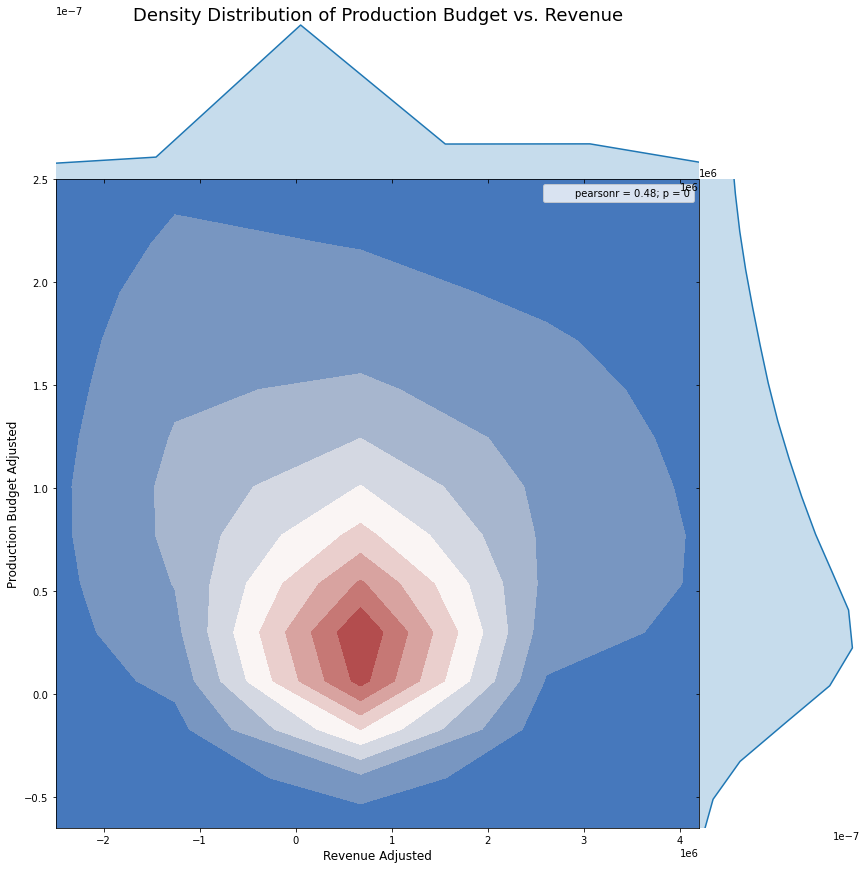

In [43]:
# defines x and y variables for the plot

x = tn_movie_budgets['revenue_adjusted']
y = tn_movie_budgets['production_budget_adjusted']

# creates 2D density  & marginal distribution:

plot = sns.jointplot(x, y, kind='kde', cmap="vlag", space=0, height=12, ratio=4)
plot.ax_marg_x.set_xlim(-2500000, 4200000)
plot.ax_marg_y.set_ylim(-650000, 2500000)
plot.set_axis_labels('Revenue Adjusted', 'Production Budget Adjusted', fontsize=12)
plt.suptitle('Density Distribution of Production Budget vs. Revenue', x=0.43, y=1.0, fontsize = 18)

# adds pearson's correlation coefficient and p-value 

plot.annotate(stats.pearsonr)

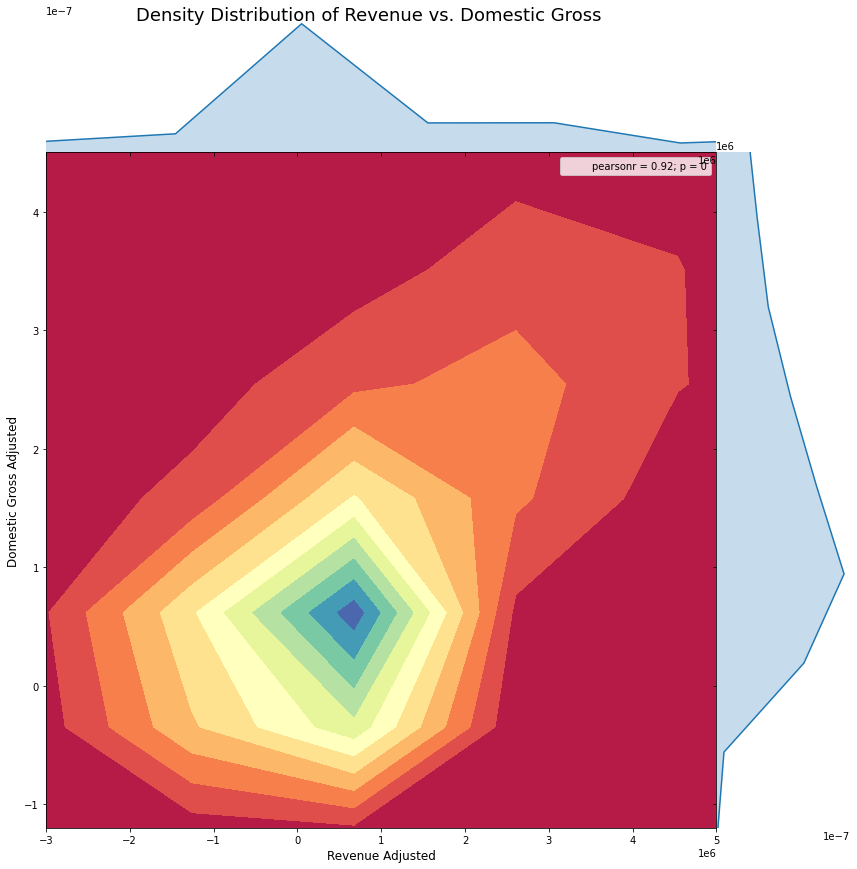

In [44]:
# defines x and y variables for the plot

x = tn_movie_budgets['revenue_adjusted']
y = tn_movie_budgets['domestic_gross_adjusted']

# creates 2D density  & marginal distribution:

plot = sns.jointplot(x, y, kind='kde', cmap="Spectral", space=0, height=12, ratio=5)
plot.ax_marg_x.set_xlim(-3000000, 5000000)
plot.ax_marg_y.set_ylim(-1200000, 4500000)
plot.set_axis_labels('Revenue Adjusted', 'Domestic Gross Adjusted', fontsize=12)
plt.suptitle('Density Distribution of Revenue vs. Domestic Gross', x=0.43, y=1.0, fontsize = 18)

# adds pearson's correlation coefficient and p-value 

plot.annotate(stats.pearsonr)

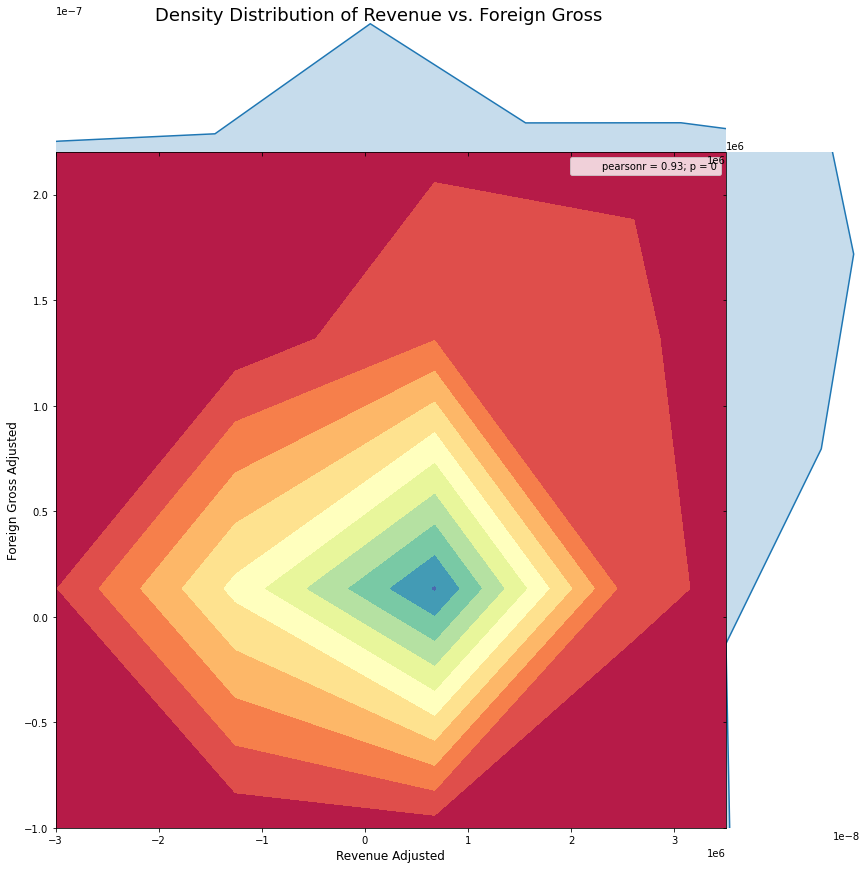

In [48]:
# defines x and y variables for the plot

x = tn_movie_budgets['revenue_adjusted']
y = tn_movie_budgets['foreign_gross_adjusted']

# creates 2D density  & marginal distribution:

plot = sns.jointplot(x, y, kind='kde', cmap="Spectral", space=0, height=12, ratio=5)
plot.ax_marg_x.set_xlim(-3000000, 3500000)
plot.ax_marg_y.set_ylim(-1000000, 2200000)
plot.set_axis_labels('Revenue Adjusted', 'Foreign Gross Adjusted', fontsize=12)
plt.suptitle('Density Distribution of Revenue vs. Foreign Gross', x=0.43, y=1.0, fontsize = 18)

# adds pearson's correlation coefficient and p-value 

plot.annotate(stats.pearsonr)